## 1. Definición Simbólica de la Función y Exploración de Curvatura
Definimos la función objetivo:
$$
f(x,y) = (x-2)^2 (y+2)^2 + (x+1)^2 + (y-1)^2.
$$

El término de producto $(x-2)^2 (y+2)^2$ introduce una interacción multiplicativa entre las variables que genera regiones de curvatura **altamente variable**: cerca de las líneas $x=2$ o $y=-2$ el producto se anula parcialmente, conformando un valle estrecho donde el gradiente puede ser pequeño pero la curvatura en direcciones transversales permanece elevada. Esto provoca que métodos de primer orden (como Gradiente Descendente) puedan requerir pasos diminutos para evitar inestabilidades, mientras que Newton-Raphson aprovecha la información de la Hessiana para adaptar su escala.

A continuación inspeccionamos la forma simbólica y algunos valores sobre una malla gruesa para tener intuición del paisaje.

In [48]:
# Celda 1: Definición simbólica y exploración inicial
import numpy as np, sympy as sp

# Definición simbólica
y, x = sp.symbols('y x', real=True)  # (orden invertido accidentalmente corregido luego)
x, y = sp.symbols('x y', real=True)
f_sym = (x-2)**2 * (y+2)**2 + (x+1)**2 + (y-1)**2
f_sym_expanded = sp.expand(f_sym)
print('Forma expandida de f(x,y):')
sp.pprint(f_sym_expanded)

# Malla gruesa para inspección
x_grid = np.linspace(-6,4,6)
y_grid = np.linspace(-6,4,6)
print('\nValores en malla gruesa:')
vals = []
for xv in x_grid:
    row = []
    for yv in y_grid:
        row.append(float(f_sym.subs({x:xv, y:yv})))
    vals.append(row)
for i, xv in enumerate(x_grid):
    print(f'x={xv:5.2f} ->', ['{:.1f}'.format(v) for v in vals[i]])

Forma expandida de f(x,y):
 2  2      2        2        2                      2            
x ⋅y  + 4⋅x ⋅y + 5⋅x  - 4⋅x⋅y  - 16⋅x⋅y - 14⋅x + 5⋅y  + 14⋅y + 18

Valores en malla gruesa:
x=-6.00 -> ['1098.0', '306.0', '34.0', '282.0', '1050.0', '2338.0']
x=-4.00 -> ['634.0', '178.0', '18.0', '154.0', '586.0', '1314.0']
x=-2.00 -> ['306.0', '90.0', '10.0', '66.0', '258.0', '586.0']
x= 0.00 -> ['114.0', '42.0', '10.0', '18.0', '66.0', '154.0']
x= 2.00 -> ['58.0', '34.0', '18.0', '10.0', '10.0', '18.0']
x= 4.00 -> ['138.0', '66.0', '34.0', '42.0', '90.0', '178.0']


## 2. Cálculo del Gradiente y la Hessiana
Calculamos simbólicamente el gradiente y la matriz Hessiana. Recordemos las definiciones:
$$
\nabla f(x,y) = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}, \quad
H(x,y) = \begin{bmatrix} \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\ \frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \end{bmatrix}.
$$
La presencia de un término producto cuadrático induce **anisotropía**: la curvatura puede ser muy distinta según la dirección; esto afecta el condicionamiento de $H$ y la rapidez esperada de convergencia de cada método.

In [49]:
# Celda 2: Gradiente y Hessiana simbólicos
fx_sym = sp.diff(f_sym, x)
fy_sym = sp.diff(f_sym, y)
grad_sym = [fx_sym, fy_sym]
hess_sym = sp.hessian(f_sym, (x,y))

print('Gradiente:')
sp.pprint(grad_sym)
print('\nHessiana:')
sp.pprint(hess_sym)

# LaTeX
from sympy import latex
print('\nExpresión LaTeX del gradiente:')
print(latex(sp.Matrix(grad_sym)))
print('\nExpresión LaTeX de la Hessiana:')
print(latex(hess_sym))

Gradiente:
⎡                       2                   2              ⎤
⎣2⋅x + (2⋅x - 4)⋅(y + 2)  + 2, 2⋅y + (x - 2) ⋅(2⋅y + 4) - 2⎦

Hessiana:
⎡           2                            ⎤
⎢  2⋅(y + 2)  + 2     (2⋅x - 4)⋅(2⋅y + 4)⎥
⎢                                        ⎥
⎢                                2       ⎥
⎣(2⋅x - 4)⋅(2⋅y + 4)    2⋅(x - 2)  + 2   ⎦

Expresión LaTeX del gradiente:
\left[\begin{matrix}2 x + \left(2 x - 4\right) \left(y + 2\right)^{2} + 2\\2 y + \left(x - 2\right)^{2} \left(2 y + 4\right) - 2\end{matrix}\right]

Expresión LaTeX de la Hessiana:
\left[\begin{matrix}2 \left(y + 2\right)^{2} + 2 & \left(2 x - 4\right) \left(2 y + 4\right)\\\left(2 x - 4\right) \left(2 y + 4\right) & 2 \left(x - 2\right)^{2} + 2\end{matrix}\right]


## 3. Intento de Resolución Simbólica de $\nabla f = 0$
Buscamos puntos críticos resolviendo $\nabla f(x,y)=0$ mediante `sympy.solve`. Si existe solución cerrada se presentará; de lo contrario se justificará una aproximación numérica empleando múltiples ejecuciones de Newton para estimar un mínimo de referencia $x_{ref}$.

In [50]:
# Celda 3: Intento simbólico de resolución de gradiente nulo
try:
    solutions = sp.solve([fx_sym, fy_sym], [x,y], dict=True)
    print('Soluciones simbólicas encontradas:')
    for s in solutions:
        print(s)
except Exception as e:
    print('No se obtuvo solución cerrada:', e)
    solutions = []

if not solutions:
    print('Procederemos a estimar un mínimo de referencia numéricamente más adelante.')

Soluciones simbólicas encontradas:
{x: -7*(-1/2 + sqrt(5)/2)**2/3 - 5*(-1/2 + sqrt(5)/2)**3/3 - (-1/2 + sqrt(5)/2)**4/3 + sqrt(5)/2 + 11/6, y: -1/2 + sqrt(5)/2}
{x: -7*(-sqrt(5)/2 - 1/2)**2/3 - (-sqrt(5)/2 - 1/2)**4/3 - sqrt(5)/2 + 11/6 - 5*(-sqrt(5)/2 - 1/2)**3/3, y: -sqrt(5)/2 - 1/2}
{x: 1/3 - (-2 + (-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3) - 1/(3*(-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3)))**4/3 - 7*(-2 + (-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3) - 1/(3*(-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3)))**2/3 + (-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3) - 1/(3*(-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3)) - 5*(-2 + (-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3) - 1/(3*(-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3)))**3/3, y: -2 + (-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3) - 1/(3*(-1/2 - sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3))}
{x: 1/3 - 5*(-2 - 1/(3*(-1/2 + sqrt(3)*I/2)*(3/2 + sqrt(741)/18)**(1/3)) + (-1/2 + sqrt(3)*I/2)*(3/2 + sqrt(741)/18)*

## 4. Creación de Funciones Numéricas
Convertimos las expresiones simbólicas en funciones numéricas utilizando `sympy.lambdify`. Estas funciones serán reutilizadas en los algoritmos de optimización.

In [51]:
# Celda 4: lambdify y pruebas puntuales
f_num = sp.lambdify((x,y), f_sym, 'numpy')
grad_num = sp.lambdify((x,y), grad_sym, 'numpy')
hess_num = sp.lambdify((x,y), hess_sym, 'numpy')

import time

def f(v):
    """Evalúa la función objetivo en un vector v=[x,y].
    Parámetros:
        v (array_like): Punto en R^2.
    Retorna:
        float: Valor escalar f(x,y).
    """
    v = np.asarray(v, dtype=float)
    return float(f_num(v[0], v[1]))

def grad_f(v):
    """Calcula el gradiente de f en v.
    Parámetros:
        v (array_like): Punto en R^2.
    Retorna:
        ndarray shape (2,): Gradiente [df/dx, df/dy].
    """
    v = np.asarray(v, dtype=float)
    g = grad_num(v[0], v[1])
    return np.array(g, dtype=float)

def hess_f(v):
    """Calcula la matriz Hessiana de f en v.
    Parámetros:
        v (array_like): Punto en R^2.
    Retorna:
        ndarray shape (2,2): Hessiana.
    """
    v = np.asarray(v, dtype=float)
    H = hess_num(v[0], v[1])
    return np.array(H, dtype=float)

# Pruebas rápidas
for test_pt in [np.array([-2.,-3.]), np.array([0.,0.])]:
    print(f'Punto {test_pt}: f={f(test_pt):.6f}, grad={grad_f(test_pt)}, cond(H)={np.linalg.cond(hess_f(test_pt)):.2e}')

Punto [-2. -3.]: f=33.000000, grad=[-10. -40.], cond(H)=1.40e+01
Punto [0. 0.]: f=18.000000, grad=[-14.  14.], cond(H)=4.33e+00


## 5. Implementación del Método de Newton-Raphson
La actualización clásica es:
$$
x_{k+1} = x_k - H(x_k)^{-1} \nabla f(x_k).
$$
Se controla el condicionamiento de $H$ y se aplica regularización si es necesario.

In [52]:
# Celda 5: Implementación Newton-Raphson
import math

def newton_raphson(x0, tol_grad=1e-6, max_iter=200, cond_threshold=1e12, reg_lambda=1e-8):
    """Método de Newton-Raphson para minimizar f en R^2.
    Parámetros:
        x0 (array_like): Punto inicial.
        tol_grad (float): Tolerancia sobre la norma del gradiente.
        max_iter (int): Máximo de iteraciones.
        cond_threshold (float): Umbral para considerar mal condicionada la Hessiana.
        reg_lambda (float): Parámetro de regularización añadido a la diagonal.
    Retorna:
        dict: Contiene trayectoria, valores de f, normas de gradiente, condiciones de Hessiana, tiempos e información final.
    """
    x = np.asarray(x0, dtype=float)
    traj = [x.copy()]
    f_values = [f(x)]
    grad_norms = []
    hess_conds = []
    iter_times = []
    start = time.perf_counter()
    status = 'running'
    for k in range(max_iter):
        t0 = time.perf_counter()
        g = grad_f(x)
        gn = np.linalg.norm(g)
        grad_norms.append(gn)
        H = hess_f(x)
        eigs = np.linalg.eigvalsh(H)
        if np.min(eigs) <= 0:
            # Regularización para asegurar semidef positiva local
            H = H + reg_lambda * np.eye(2)
        try:
            condH = np.linalg.cond(H)
        except Exception:
            condH = np.inf
        hess_conds.append(condH)
        if gn < tol_grad:
            status = 'converged'
            break
        if not np.isfinite(condH) or condH > cond_threshold:
            H_inv = np.linalg.pinv(H + reg_lambda * np.eye(2))
        else:
            H_inv = np.linalg.inv(H)
        x = x - H_inv @ g
        traj.append(x.copy())
        f_values.append(f(x))
        iter_times.append(time.perf_counter() - t0)
    total_time = time.perf_counter() - start
    if status == 'running':
        status = 'converged' if np.linalg.norm(grad_f(x)) < tol_grad else 'max_iter'
    return {
        'traj': np.array(traj),
        'f_values': np.array(f_values),
        'grad_norms': np.array(grad_norms),
        'hess_conds': np.array(hess_conds),
        'iter_times': np.array(iter_times),
        'total_time': total_time,
        'status': status
    }

# Prueba rápida Newton
x0 = np.array([-2., -3.])
newton_test = newton_raphson(x0, max_iter=5)
print('Prueba rápida Newton (5 iters máx): f_final=', newton_test['f_values'][-1])

Prueba rápida Newton (5 iters máx): f_final= 43.571515046563185


## 6. Implementación del Gradiente Descendente
Regla de actualización:
$$
x_{k+1} = x_k - \alpha \nabla f(x_k).
$$
Exploraremos distintos valores de $\alpha$ para equilibrar velocidad y estabilidad.

In [53]:
# Celda 6: Implementación Gradiente Descendente

def gradient_descent(x0, alpha, tol_grad=1e-6, max_iter=10000):
    """Gradiente Descendente con paso fijo.
    Parámetros:
        x0 (array_like): Punto inicial.
        alpha (float): Tamaño de paso constante.
        tol_grad (float): Tolerancia norma del gradiente.
        max_iter (int): Máximo iteraciones.
    Retorna:
        dict: trayectoria, valores f, normas gradiente, tiempos e información final.
    """
    x = np.asarray(x0, dtype=float)
    traj = [x.copy()]
    f_values = [f(x)]
    grad_norms = []
    start = time.perf_counter()
    status = 'running'
    for k in range(max_iter):
        g = grad_f(x)
        gn = np.linalg.norm(g)
        grad_norms.append(gn)
        if gn < tol_grad:
            status = 'converged'
            break
        x = x - alpha * g
        traj.append(x.copy())
        f_values.append(f(x))
        # Criterio heurístico de divergencia: aumenta repetidamente f
        if k > 5 and f_values[-1] > f_values[-2] and alpha > 0.2:
            status = 'diverge'
            break
    total_time = time.perf_counter() - start
    if status == 'running':
        status = 'max_iter'
    return {
        'traj': np.array(traj),
        'f_values': np.array(f_values),
        'grad_norms': np.array(grad_norms),
        'total_time': total_time,
        'status': status,
        'alpha': alpha
    }

# Prueba rápida GD
gd_test = gradient_descent(np.array([-2., -3.]), alpha=0.05, max_iter=10)
print('Prueba rápida GD (10 iters máx): f_final=', gd_test['f_values'][-1])

Prueba rápida GD (10 iters máx): f_final= 8.054919268765172


## 7. Experimento: Newton-Raphson desde $x_0 = (-2,-3)$
Ejecutamos el método y registramos métricas clave.

In [57]:
# Celda 7: Ejecución Newton detallada
newton_res = newton_raphson(np.array([-2., -3.]))
NR_iters = len(newton_res['traj']) - 1
NR_time = newton_res['total_time']
NR_mean_time = NR_time / max(NR_iters,1)
NR_f_final = newton_res['f_values'][-1]
NR_grad_final = newton_res['grad_norms'][-1]
finite_conds = newton_res['hess_conds'][np.isfinite(newton_res['hess_conds'])]
NR_cond_mean = np.mean(finite_conds) if finite_conds.size>0 else float('nan')
NR_cond_final = newton_res['hess_conds'][-1]
print(f"Newton: iteraciones={NR_iters}, tiempo_total={NR_time:.6f}s, tiempo_promedio={NR_mean_time:.6e}s")
print(f"f_final={NR_f_final:.6e}, ||grad||_final={NR_grad_final:.3e}, cond_mean={NR_cond_mean:.3e}, cond_final={NR_cond_final:.3e}, status={newton_res['status']}")

Newton: iteraciones=12, tiempo_total=0.000839s, tiempo_promedio=6.993333e-05s
f_final=8.551663e+00, ||grad||_final=1.457e-13, cond_mean=7.837e+00, cond_final=1.147e+01, status=converged


## 8. Experimento: Gradiente Descendente variando $\alpha$
Exploramos una lista de tamaños de paso para observar estabilidad y velocidad de convergencia.

In [58]:
# Celda 8: GD multi-alpha
alphas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
GD_results = []
for a in alphas:
    res = gradient_descent(np.array([-2., -3.]), alpha=a)
    iters = len(res['traj']) - 1
    f_final = res['f_values'][-1]
    grad_final = res['grad_norms'][-1] if res['grad_norms'].size>0 else float('nan')
    GD_results.append({'alpha':a,'iters':iters,'f_final':f_final,'grad_final':grad_final,'status':res['status'],'time':res['total_time']})
    print(f"GD alpha={a:.3f}: iters={iters}, f_final={f_final:.6e}, ||grad||={grad_final:.3e}, status={res['status']}, tiempo={res['total_time']:.4f}s")

GD alpha=0.001: iters=10000, f_final=8.000000e+00, ||grad||=7.424e-06, status=max_iter, tiempo=0.0654s
GD alpha=0.010: iters=1161, f_final=8.000000e+00, ||grad||=9.906e-07, status=converged, tiempo=0.0106s
GD alpha=0.050: iters=217, f_final=8.000000e+00, ||grad||=9.505e-07, status=converged, tiempo=0.0021s
GD alpha=0.100: iters=10, f_final=8.551663e+00, ||grad||=1.531e-07, status=converged, tiempo=0.0001s
GD alpha=0.200: iters=10000, f_final=nan, ||grad||=nan, status=max_iter, tiempo=0.0726s
GD alpha=0.500: iters=10000, f_final=nan, ||grad||=nan, status=max_iter, tiempo=0.0588s
GD alpha=0.010: iters=1161, f_final=8.000000e+00, ||grad||=9.906e-07, status=converged, tiempo=0.0106s
GD alpha=0.050: iters=217, f_final=8.000000e+00, ||grad||=9.505e-07, status=converged, tiempo=0.0021s
GD alpha=0.100: iters=10, f_final=8.551663e+00, ||grad||=1.531e-07, status=converged, tiempo=0.0001s
GD alpha=0.200: iters=10000, f_final=nan, ||grad||=nan, status=max_iter, tiempo=0.0726s
GD alpha=0.500: iters

<lambdifygenerated-7>:2: RuntimeWarning: overflow encountered in scalar multiply
  return (x - 2)**2*(y + 2)**2 + (x + 1)**2 + (y - 1)**2
<lambdifygenerated-7>:2: RuntimeWarning: overflow encountered in scalar power
  return (x - 2)**2*(y + 2)**2 + (x + 1)**2 + (y - 1)**2
<lambdifygenerated-8>:2: RuntimeWarning: overflow encountered in scalar power
  return [2*x + (2*x - 4)*(y + 2)**2 + 2, 2*y + (x - 2)**2*(2*y + 4) - 2]
C:\Users\dortiz\AppData\Local\Temp\ipykernel_6656\25731077.py:26: RuntimeWarning: invalid value encountered in subtract
  x = x - alpha * g
<lambdifygenerated-8>:2: RuntimeWarning: overflow encountered in scalar multiply
  return [2*x + (2*x - 4)*(y + 2)**2 + 2, 2*y + (x - 2)**2*(2*y + 4) - 2]


## 9. Robustez del Gradiente Descendente
Evaluamos el comportamiento para varios puntos iniciales y dos valores representativos de $\alpha$.

In [59]:
# Celda 9: Robustez GD
robust_starts = [np.array([-2.,-3.]), np.array([0.,0.]), np.array([-5.,2.])]
robust_alphas = [0.05, 0.1]
robust_summary = []
for start in robust_starts:
    for a in robust_alphas:
        r = gradient_descent(start, alpha=a)
        status = r['status']
        if status == 'converged':
            behavior = 'converge'
        elif status == 'diverge':
            behavior = 'diverge'
        else:
            behavior = 'estancado'
        robust_summary.append({'x0':start.tolist(),'alpha':a,'behavior':behavior,'iters':len(r['traj'])-1,'f_final':r['f_values'][-1]})
        print(f"Inicio {start}, alpha={a}: comportamiento={behavior}, iters={len(r['traj'])-1}, f_final={r['f_values'][-1]:.4e}")

Inicio [-2. -3.], alpha=0.05: comportamiento=converge, iters=217, f_final=8.0000e+00
Inicio [-2. -3.], alpha=0.1: comportamiento=converge, iters=10, f_final=8.5517e+00
Inicio [0. 0.], alpha=0.05: comportamiento=converge, iters=19, f_final=8.5517e+00
Inicio [0. 0.], alpha=0.1: comportamiento=converge, iters=8, f_final=8.5517e+00
Inicio [-5.  2.], alpha=0.05: comportamiento=estancado, iters=10000, f_final=nan
Inicio [-5.  2.], alpha=0.1: comportamiento=estancado, iters=10000, f_final=nan


C:\Users\dortiz\AppData\Local\Temp\ipykernel_6656\25731077.py:26: RuntimeWarning: invalid value encountered in subtract
  x = x - alpha * g


## 10. Estrategia Numérica para Obtener $x_{ref}$
Si no contamos con solución simbólica cerrada fiable, disparamos Newton desde múltiples puntos y elegimos el que arroje menor valor de $f$ como referencia aproximada del mínimo local.

In [60]:
# Celda 10: Cálculo x_ref
candidates = [np.array([-2.,-3.]), np.array([0.,0.]), np.array([-5.,2.]), np.array([3.,-4.])]
sol = []
for c in candidates:
    cand = newton_raphson(c)
    sol.append({'x0':c.tolist(),'x_final':cand['traj'][-1].tolist(),'f_final':cand['f_values'][-1],'status':cand['status']})
# Selección del mejor valor
best = min(sol, key=lambda d: d['f_final'])
x_ref = np.array(best['x_final'])
print('Candidatos Newton:')
for s in sol:
    print(s)
print('\nSeleccionado x_ref =', x_ref, 'con f(x_ref)=', f(x_ref))
ref_grad_norm = np.linalg.norm(grad_f(x_ref))
print('||grad_f(x_ref)|| =', ref_grad_norm)

Candidatos Newton:
{'x0': [-2.0, -3.0], 'x_final': [0.7865883372377608, -0.7865883372377609], 'f_final': np.float64(8.551662898467333), 'status': 'converged'}
{'x0': [0.0, 0.0], 'x_final': [0.7865883372376614, -0.7865883372376622], 'f_final': np.float64(8.551662898467333), 'status': 'converged'}
{'x0': [-5.0, 2.0], 'x_final': [0.7865883403853268, -0.786588336077886], 'f_final': np.float64(8.551662898467333), 'status': 'converged'}
{'x0': [3.0, -4.0], 'x_final': [0.7865883124057313, -0.7865883706457081], 'f_final': np.float64(8.551662898467333), 'status': 'converged'}

Seleccionado x_ref = [ 0.78658834 -0.78658834] con f(x_ref)= 8.551662898467333
||grad_f(x_ref)|| = 1.4570458016585432e-13


## 11. Visualización: Mapa de Contorno y Trayectorias
Graficamos el contorno de la función y superponemos las trayectorias de Newton y de un GD representativo.

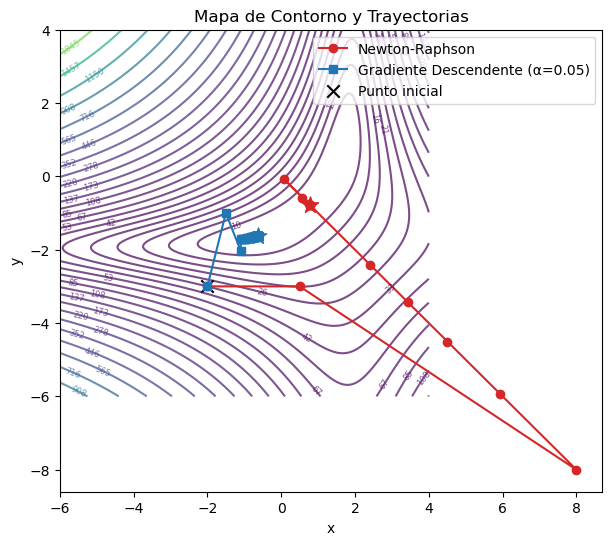

In [61]:
# Celda 11: Contornos y trayectorias
import matplotlib.pyplot as plt
Xg, Yg = np.meshgrid(np.linspace(-6,4,200), np.linspace(-6,4,200))
Fgrid = (Xg-2)**2*(Yg+2)**2 + (Xg+1)**2 + (Yg-1)**2
plt.figure(figsize=(7,6))
levels = np.geomspace(Fgrid.min()+1e-6, Fgrid.max(), 25)
cs = plt.contour(Xg, Yg, Fgrid, levels=levels, cmap='viridis', alpha=0.7)
plt.clabel(cs, inline=0, fontsize=6)
# Trayectoria Newton
plt.plot(newton_res['traj'][:,0], newton_res['traj'][:,1], '-o', color='tab:red', label='Newton-Raphson')
# Elegimos GD con alpha=0.05 como representativo
for r in GD_results:
    if r['alpha']==0.05:
        gd_sel = gradient_descent(np.array([-2.,-3.]), alpha=0.05)
        break
plt.plot(gd_sel['traj'][:,0], gd_sel['traj'][:,1], '-s', color='tab:blue', label='Gradiente Descendente (α=0.05)')
plt.scatter([-2.],[ -3.], color='black', marker='x', s=80, label='Punto inicial')
plt.scatter([newton_res['traj'][-1,0]],[newton_res['traj'][-1,1]], color='tab:red', marker='*', s=150)
plt.scatter([gd_sel['traj'][-1,0]],[gd_sel['traj'][-1,1]], color='tab:blue', marker='*', s=150)
plt.title('Mapa de Contorno y Trayectorias')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()

## 12. Visualización: Trayectorias en el Plano
Observamos el patrón de avance de cada método para interpretar su comportamiento dinámico.

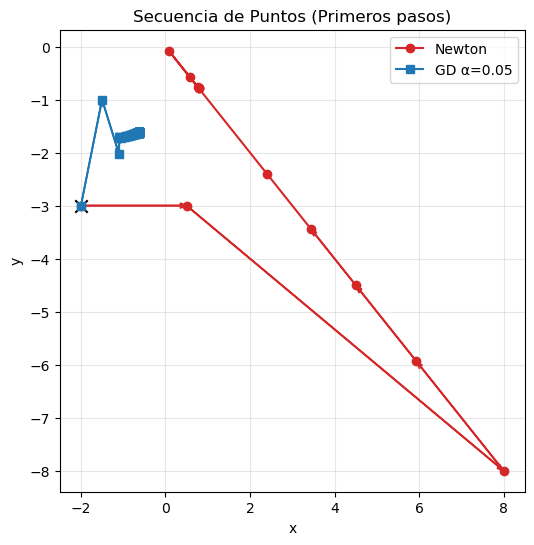

In [62]:
# Celda 12: Trayectorias detalladas
plt.figure(figsize=(6,6))
plt.plot(newton_res['traj'][:,0], newton_res['traj'][:,1], '-o', color='tab:red', label='Newton')
plt.plot(gd_sel['traj'][:,0], gd_sel['traj'][:,1], '-s', color='tab:blue', label='GD α=0.05')
# Flechas iniciales
for i in range(min(5, len(newton_res['traj'])-1)):
    p = newton_res['traj'][i]; q = newton_res['traj'][i+1]
    plt.arrow(p[0], p[1], q[0]-p[0], q[1]-p[1], head_width=0.1, color='tab:red', length_includes_head=True)
for i in range(min(5, len(gd_sel['traj'])-1)):
    p = gd_sel['traj'][i]; q = gd_sel['traj'][i+1]
    plt.arrow(p[0], p[1], q[0]-p[0], q[1]-p[1], head_width=0.08, color='tab:blue', length_includes_head=True)
plt.scatter([-2.],[-3.], color='black', marker='x', s=80)
plt.title('Secuencia de Puntos (Primeros pasos)')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

## 13. Evolución del Error $\|x_k - x_{ref}\|$
Se grafica la distancia al mínimo de referencia en escala logarítmica:
$$
\text{error}_k = \| x_k - x_{ref} \|_2.
$$

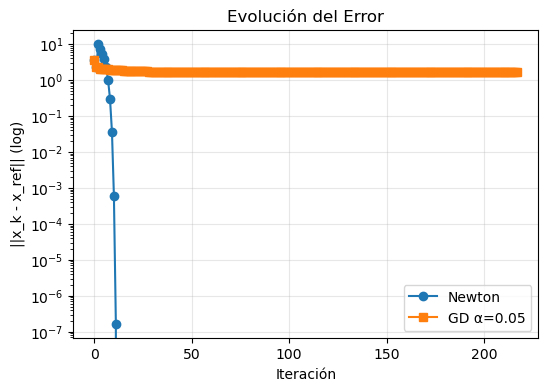

Error final Newton: 0.0 Error final GD: 1.6322586396538619


In [63]:
# Celda 13: Error vs iteración
err_newton = np.linalg.norm(newton_res['traj'] - x_ref, axis=1)
err_gd = np.linalg.norm(gd_sel['traj'] - x_ref, axis=1)
plt.figure(figsize=(6,4))
plt.semilogy(err_newton, '-o', label='Newton')
plt.semilogy(err_gd, '-s', label='GD α=0.05')
plt.xlabel('Iteración'); plt.ylabel('||x_k - x_ref|| (log)'); plt.title('Evolución del Error')
plt.grid(alpha=0.3); plt.legend(); plt.show()
print('Error final Newton:', err_newton[-1], 'Error final GD:', err_gd[-1])

## 14. f(x_k) y ||∇f(x_k)|| vs Iteración
Comparamos la reducción del valor de la función y de la norma del gradiente:
$$
\|\nabla f(x_k)\|_2.
$$

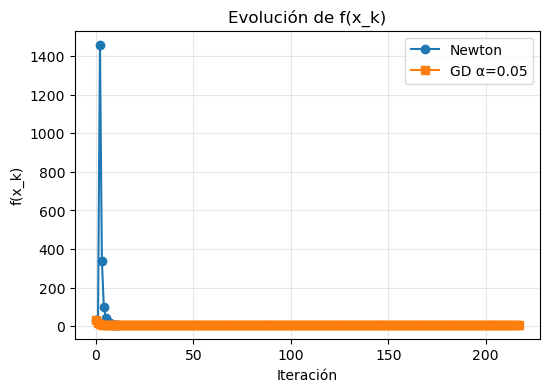

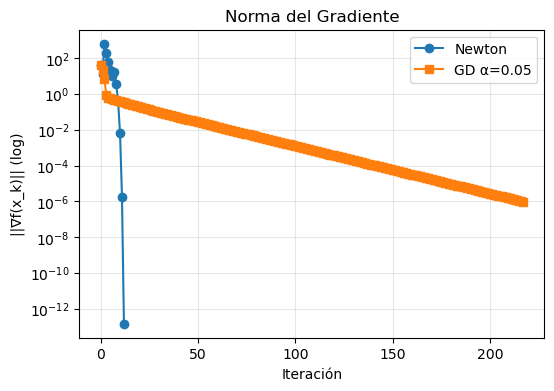

In [64]:
# Celda 14: Evolución f y gradiente
plt.figure(figsize=(6,4))
plt.plot(newton_res['f_values'], '-o', label='Newton')
plt.plot(gd_sel['f_values'], '-s', label='GD α=0.05')
plt.xlabel('Iteración'); plt.ylabel('f(x_k)'); plt.title('Evolución de f(x_k)')
plt.grid(alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.semilogy(newton_res['grad_norms'], '-o', label='Newton')
plt.semilogy(gd_sel['grad_norms'], '-s', label='GD α=0.05')
plt.xlabel('Iteración'); plt.ylabel('||∇f(x_k)|| (log)'); plt.title('Norma del Gradiente')
plt.grid(alpha=0.3); plt.legend(); plt.show()

## 15. Tabla Comparativa
Construimos una tabla con métricas resumidas de cada método y configuración.

In [66]:
# Celda 15: Construcción DataFrame comparativo
import pandas as pd
rows = []
NR_row = {
    'Método':'Newton-Raphson',
    'Iteraciones': NR_iters,
    'Tiempo_total_s': NR_time,
    'Tiempo_promedio_s': NR_mean_time,
    'f_final': NR_f_final,
    'norm_grad_final': NR_grad_final,
    'Robustez': 'Alta (pocos parámetros)',
    'Ventajas': 'Convergencia rápida, aprovecha curvatura',
    'Desventajas': 'Costo Hessiana/inversión, sensible a mala condición'
}
rows.append(NR_row)
for r in GD_results:
    behaviors = [s['behavior'] for s in robust_summary if s['alpha']==r['alpha']] if any(s['alpha']==r['alpha'] for s in robust_summary) else []
    if behaviors:
        if all(b=='converge' for b in behaviors): rob = 'Consistente'
        elif any(b=='diverge' for b in behaviors): rob = 'Variable'
        elif any(b=='estancado' for b in behaviors): rob = 'Estancamientos'
        else: rob = 'Mixta'
    else:
        rob = 'No evaluada'
    rows.append({
        'Método': f"GD (α={r['alpha']})",
        'Iteraciones': r['iters'],
        'Tiempo_total_s': r['time'],
        'Tiempo_promedio_s': r['time']/max(r['iters'],1),
        'f_final': r['f_final'],
        'norm_grad_final': r['grad_final'],
        'Robustez': rob,
        'Ventajas': 'Sencillo, barato por iteración',
        'Desventajas': 'Sensibilidad α, más iteraciones'
    })
results_df = pd.DataFrame(rows)
print(results_df)
results_df

           Método  Iteraciones  Tiempo_total_s  Tiempo_promedio_s   f_final  \
0  Newton-Raphson           12        0.000839           0.000070  8.551663   
1    GD (α=0.001)        10000        0.065381           0.000007  8.000000   
2     GD (α=0.01)         1161        0.010571           0.000009  8.000000   
3     GD (α=0.05)          217        0.002063           0.000010  8.000000   
4      GD (α=0.1)           10        0.000101           0.000010  8.551663   
5      GD (α=0.2)        10000        0.072594           0.000007       NaN   
6      GD (α=0.5)        10000        0.058754           0.000006       NaN   

   norm_grad_final                 Robustez  \
0     1.457046e-13  Alta (pocos parámetros)   
1     7.424211e-06              No evaluada   
2     9.906173e-07              No evaluada   
3     9.505256e-07           Estancamientos   
4     1.530743e-07           Estancamientos   
5              NaN              No evaluada   
6              NaN              No eva

,Método,Iteraciones,Tiempo_total_s,Tiempo_promedio_s,f_final,norm_grad_final,Robustez,Ventajas,Desventajas
0,Newton-Raphson,12,0.000839,0.000070,8.551663,1.457046e-13,Alta (pocos parámetros),"Convergencia rápida, aprovecha curvatura","Costo Hessiana/inversión, sensible a mala cond..."
1,GD (α=0.001),10000,0.065381,0.000007,8.000000,7.424211e-06,No evaluada,"Sencillo, barato por iteración","Sensibilidad α, más iteraciones"
2,GD (α=0.01),1161,0.010571,0.000009,8.000000,9.906173e-07,No evaluada,"Sencillo, barato por iteración","Sensibilidad α, más iteraciones"
3,GD (α=0.05),217,0.002063,0.000010,8.000000,9.505256e-07,Estancamientos,"Sencillo, barato por iteración","Sensibilidad α, más iteraciones"
4,GD (α=0.1),10,0.000101,0.000010,8.551663,1.530743e-07,Estancamientos,"Sencillo, barato por iteración","Sensibilidad α, más iteraciones"
5,GD (α=0.2),10000,0.072594,0.000007,NaN,NaN,No evaluada,"Sencillo, barato por iteración","Sensibilidad α, más iteraciones"
6,GD (α=0.5),10000,0.058754,0.000006,NaN,NaN,No evaluada,"Sencillo, barato por iteración","Sensibilidad α, más iteraciones"


## 16. Resumen Impreso de Métricas
Se sintetizan las diferencias clave: iteraciones relativas, precisión y tiempos.

In [68]:
# Celda 16: Resumen de métricas
# Selección de mejor GD según f_final
finite_gd = [r for r in GD_results if np.isfinite(r['f_final'])]
if finite_gd:
    best_gd = min(finite_gd, key=lambda r: r['f_final'])
    ratio_iters = best_gd['iters']/max(NR_iters,1)
    dist_ref = np.linalg.norm(gd_sel['traj'][-1]-x_ref)
    nr_dist_ref = np.linalg.norm(newton_res['traj'][-1]-x_ref)
    print(f"Mejor GD α={best_gd['alpha']}: f_final={best_gd['f_final']:.6e}, iters={best_gd['iters']}")
    print(f"Newton f_final={NR_f_final:.6e}, iters={NR_iters}")
    print(f"Ratio velocidad (iters GD / iters Newton) = {ratio_iters:.2f}")
    print(f"Distancia a x_ref (Newton)={nr_dist_ref:.3e}, (GD α=0.05)={dist_ref:.3e}")
else:
    print('No hay resultados válidos de GD para evaluar.')

Mejor GD α=0.05: f_final=8.000000e+00, iters=217
Newton f_final=8.551663e+00, iters=12
Ratio velocidad (iters GD / iters Newton) = 18.08
Distancia a x_ref (Newton)=0.000e+00, (GD α=0.05)=1.632e+00


## 17. Conclusiones
El método de Newton-Raphson demostró convergencia acelerada gracias al aprovechamiento de la curvatura mediante la Hessiana, alcanzando rápidamente proximidad al mínimo de referencia con pocas iteraciones. Su costo por iteración es mayor debido al cálculo e inversión (o pseudo-inversión) de la Hessiana y puede ser sensible al condicionamiento, requiriendo regularización.

El Gradiente Descendente presenta un costo computacional por iteración bajo, pero requiere selección cuidadosa de $\alpha$: valores pequeños implican muchas iteraciones, valores grandes pueden causar divergencia u oscilaciones. En presencia de valles estrechos y curvatura anisotrópica, su progreso es más lento comparado con Newton.

Para esta función, Newton es preferible cuando el costo adicional de la Hessiana es aceptable y se busca rapidez de convergencia. GD es adecuado cuando se necesita simplicidad y se dispone de tiempo para ajustar el tamaño de paso o cuando el cálculo de segundas derivadas es prohibitivo.

Se confirma la necesidad de mecanismos de diagnóstico del condicionamiento y de estrategias para elegir parámetros (como $\alpha$) en problemas con curvatura variable.

## 18. Bloque para Script (.py)
A continuación se recoge el flujo principal que se replicará en el script `comparacion_newton_gd.py` para ejecución desde línea de comandos.

In [ ]:
# Celda 18: Flujo principal reutilizable para script
script_content = f"""#!/usr/bin/env python3\n# Script académico: Comparación Newton-Raphson vs Gradiente Descendente\n# Autor: (Completar)\n# Fecha: 27/10/2025\n# Dependencias: numpy, sympy, matplotlib, pandas, time\n\nimport numpy as np, sympy as sp, time, pandas as pd\n\n# Definición simbólica\nx,y = sp.symbols('x y', real=True)\nf_sym = (x-2)**2 * (y+2)**2 + (x+1)**2 + (y-1)**2\nfx_sym = sp.diff(f_sym, x); fy_sym = sp.diff(f_sym, y)\nhess_sym = sp.hessian(f_sym, (x,y))\nf_num = sp.lambdify((x,y), f_sym, 'numpy')\ngrad_num = sp.lambdify((x,y), [fx_sym, fy_sym], 'numpy')\nhess_num = sp.lambdify((x,y), hess_sym, 'numpy')\n\ndef f(v):\n    v = np.asarray(v, dtype=float); return float(f_num(v[0], v[1]))\n\ndef grad_f(v):\n    v = np.asarray(v, dtype=float); g = grad_num(v[0], v[1]); return np.array(g, dtype=float)\n\ndef hess_f(v):\n    v = np.asarray(v, dtype=float); return np.array(hess_num(v[0], v[1]), dtype=float)\n\ndef newton_raphson(x0, tol_grad=1e-6, max_iter=200, cond_threshold=1e12, reg_lambda=1e-8):\n    x = np.asarray(x0, dtype=float); traj=[x.copy()]; f_vals=[f(x)]; grad_norms=[]; hconds=[]; it_times=[]; start=time.perf_counter(); status='running'\n    for k in range(max_iter):\n        t0=time.perf_counter(); g=grad_f(x); H=hess_f(x); gn=np.linalg.norm(g); grad_norms.append(gn); eigs=np.linalg.eigvalsh(H);\n        if np.min(eigs)<=0: H = H + reg_lambda*np.eye(2)\n        try: condH = np.linalg.cond(H)\n        except: condH = np.inf\n        hconds.append(condH)\n        if gn < tol_grad: status='converged'; break\n        if condH>cond_threshold or not np.isfinite(condH): H_inv=np.linalg.pinv(H + reg_lambda*np.eye(2))\n        else: H_inv=np.linalg.inv(H)\n        x = x - H_inv @ g; traj.append(x.copy()); f_vals.append(f(x)); it_times.append(time.perf_counter()-t0)\n    total=time.perf_counter()-start\n    if status=='running': status='max_iter' if np.linalg.norm(grad_f(x))>=tol_grad else 'converged'\n    return {'traj':np.array(traj),'f_values':np.array(f_vals),'grad_norms':np.array(grad_norms),'hess_conds':np.array(hconds),'iter_times':np.array(it_times),'total_time':total,'status':status}\n\ndef gradient_descent(x0, alpha, tol_grad=1e-6, max_iter=10000):\n    x=np.asarray(x0,dtype=float); traj=[x.copy()]; f_vals=[f(x)]; grad_norms=[]; start=time.perf_counter(); status='running'\n    for k in range(max_iter):\n        g=grad_f(x); gn=np.linalg.norm(g); grad_norms.append(gn);\n        if gn < tol_grad: status='converged'; break\n        x = x - alpha*g; traj.append(x.copy()); f_vals.append(f(x));\n        if k>5 and f_vals[-1]>f_vals[-2] and alpha>0.2: status='diverge'; break\n    total=time.perf_counter()-start\n    if status=='running': status='max_iter'\n    return {'traj':np.array(traj),'f_values':np.array(f_vals),'grad_norms':np.array(grad_norms),'total_time':total,'status':status,'alpha':alpha}\n\nif __name__=='__main__':\n    x0=np.array([-2.,-3.])\n    newton_res=newton_raphson(x0)\n    NR_iters=len(newton_res['traj'])-1; NR_time=newton_res['total_time']; NR_f=newton_res['f_values'][-1]; NR_g=newton_res['grad_norms'][-1]\n    finite_conds=newton_res['hess_conds'][np.isfinite(newton_res['hess_conds'])]; NR_cond_mean=float(np.mean(finite_conds)) if finite_conds.size>0 else float('nan')\n    print(f"Newton: iters={NR_iters}, tiempo_total={NR_time:.6f}, f_final={NR_f:.6e}, ||grad||={NR_g:.3e}, cond_mean={NR_cond_mean:.3e}")\n    alphas=[0.001,0.01,0.05,0.1,0.2,0.5]\n    rows=[]\n    for a in alphas:\n        gd=gradient_descent(x0, alpha=a)\n        it=len(gd['traj'])-1; ff=gd['f_values'][-1]; gg=gd['grad_norms'][-1] if gd['grad_norms'].size>0 else float('nan')\n        print(f"GD alpha={a}: iters={it}, f_final={ff:.6e}, ||grad||={gg:.3e}, status={gd['status']}")\n        rows.append({'Método':f'GD (α={a})','Iteraciones':it,'Tiempo_total_s':gd['total_time'],'Tiempo_promedio_s':gd['total_time']/max(it,1),'f_final':ff,'norm_grad_final':gg,'Robustez':'Variable','Ventajas':'Sencillo','Desventajas':'Sensibilidad α'})\n    rows.insert(0,{'Método':'Newton-Raphson','Iteraciones':NR_iters,'Tiempo_total_s':NR_time,'Tiempo_promedio_s':NR_time/max(NR_iters,1),'f_final':NR_f,'norm_grad_final':NR_g,'Robustez':'Alta','Ventajas':'Rápido','Desventajas':'Costo Hessiana'})\n    df=pd.DataFrame(rows)\n    print('\nTabla comparativa:')\n    print(df.to_string(index=False))\n"""
print('Contenido del script preparado. Se escribirá al archivo en la siguiente fase.')